<a href="https://colab.research.google.com/github/HippocampusTeam/DNNT-TensorFlow/blob/graph/DNNT_graph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Imports

In [1]:
import csv

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.model_selection import train_test_split

In [12]:
%matplotlib inline
plt.style.use('Solarize_Light2')

from matplotlib import rcParams
rcParams['figure.figsize'] = 17, 8

%config InlineBackend.figure_format = 'retina'

In [2]:
# Load data

is_local = True

if not is_local:
    from google.colab import drive
    drive.mount('/content/drive')

# Read data in from file
with open('./banknotes/banknotes.csv' if is_local else '/content/drive/MyDrive/DNNT/data/banknotes.csv') as f:
    reader = csv.reader(f)
    next(reader)

    data = []
    for row in reader:
        data.append({
            "evidence": [float(cell) for cell in row[:4]],
            "label": 1 if row[4] == "0" else 0
        })

# Separate data into training and testing groups
evidence = [row["evidence"] for row in data]
labels = [row["label"] for row in data]
X_training, X_testing, y_training, y_testing = train_test_split(
    evidence, labels, test_size=0.4
)

In [4]:
def graph2D(model, index, x_train, y_train, n):
    weights = model.get_weights()
    if len(index) == 3:
        weights[index[0]][index[1]][index[2]] = n
    else:
        weights[index[0]][index[1]] = n
    model.set_weights(weights)
    predictions = model.predict(x_train)
    loss = tf.keras.losses.binary_crossentropy(y_train, predictions)
    if len(index) == 3:
        return model.get_weights()[index[0]][index[1]][index[2]], np.mean(loss)
    else:
        return model.get_weights()[index[0]][index[1]], np.mean(loss)


x = list()
y = list()
def add_weight(model, index):
    x.append(list())
    y.append(list())
    model_copy = tf.keras.models.clone_model(model)
    for i in np.linspace(-2, 2, 50):
        cur = graph2D(model_copy, index, X_testing, y_testing, i)
        x[-1].append(cur[0])
        y[-1].append(cur[1])
    m = y[-1].index(min(y[-1]))
    return x[-1][m], y[-1][m]


def add_all(model):
    c = 0
    w = model.get_weights()
    for i in tqdm(range(len(w))):
        for j in range(len(w[i])):
            if isinstance(w[i][j], np.ndarray):
                for k in range(len(w[i][j])):
                    m_x, m_y = add_weight(model, (i, j, k))
                    # print('The local minimum weight value is ' + str(m_x) + ', and the loss is ' + str(m_y))
                    c += 1
            else:
                m_x, m_y = add_weight(model, (i, j))
                # print('The local minimum weight value is ' + str(m_x) + ', and the loss is ' + str(m_y))
                c += 1
    return c

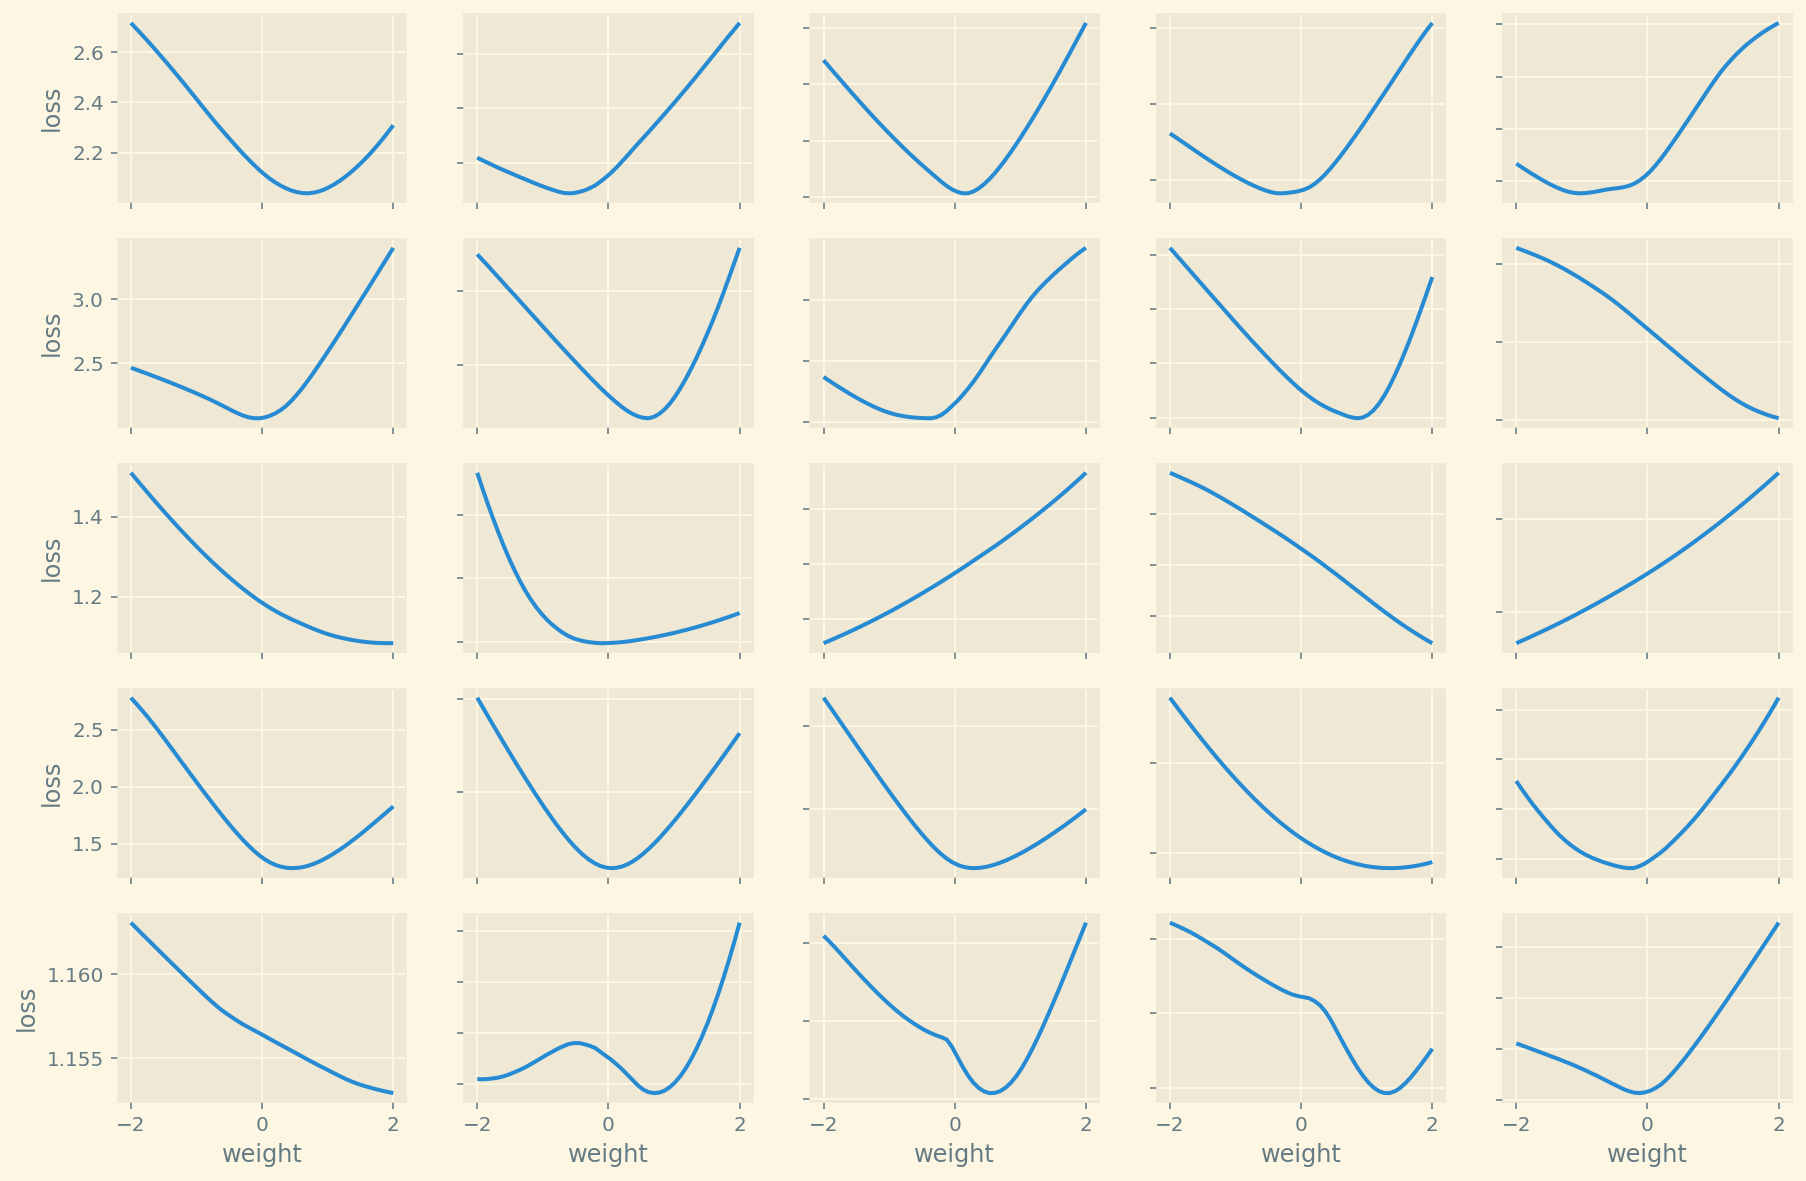

In [13]:
fig, axs = plt.subplots(5, 5, figsize=(15, 10))
for i in range(25):
    axs[i // 5, i % 5].plot(x[i], y[i])

for ax in axs.flat:
    ax.set(xlabel='weight', ylabel='loss')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

In [14]:
def graph3D(model, index1, index2, x_train, y_train, n, m):
    weights = model.get_weights()
    if len(index1) == 3:
        weights[index1[0]][index1[1]][index1[2]] = n
    else:
        weights[index1[0]][index1[1]] = n
    if len(index2) == 3:
        weights[index2[0]][index2[1]][index2[2]] = m
    else:
        weights[index2[0]][index2[1]] = m
    model.set_weights(weights)
    predictions = model.predict(x_train)
    loss = tf.keras.losses.binary_crossentropy(y_train, predictions)
    return n, m, np.mean(loss)

In [15]:
x = list()
y = list()
z = list()
x_p = list()
y_p = list()
z_p = list()
def add_weights3D(model, index1, index2, add_plain=True):
    x.append(list())
    y.append(list())
    z.append(list())
    x_p.append(list())
    y_p.append(list())
    z_p.append(list())
    model_copy = tf.keras.models.clone_model(model)
    for i in tqdm(np.linspace(-2, 2, 50)):
        for j in np.linspace(-2, 2, 50):
            cur = graph3D(model_copy, index1, index2, X_testing, y_testing, i, j)
            x[-1].append(cur[0])
            y[-1].append(cur[1])
            z[-1].append(cur[2])
    if add_plain:
        for i in tqdm(np.linspace(-2, 2, 50)):
            cur = graph3D(model_copy, index1, index2, X_testing, y_testing, i, 0)
            x_p[-1].append(cur[0])
            y_p[-1].append(cur[1])
            z_p[-1].append(cur[2])
    m = z[-1].index(min(z[-1]))
    return x[-1][m], y[-1][m], z[-1][m]


def plot3D(model, index1, index2, add_plain=True, cords=None):
    m_x, m_y, m_z = add_weights3D(model, index1, index2, add_plain=add_plain)
    print('The local minimum weight values are ' + str(m_x) + ' and ' + str(m_y) + ', and the loss is ' + str(m_z))
    fig = plt.figure(figsize=(20, 15))
    ax = fig.add_subplot(projection='3d')
    ax.plot_trisurf(x[-1], y[-1], z[-1],
                    cmap='viridis', edgecolor='none')
    ax.plot3D(x_p[-1], y_p[-1], z_p[-1], 'red', linewidth=5)
    ax.set_xlabel('weight 1')
    ax.set_ylabel('weight 2')
    ax.set_zlabel('loss')
    if cords is not None:
        ax.view_init(cords[0], cords[1])

# Simulations for paper

In [ ]:
# Create a neural network
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(3, input_shape=(4,), activation="relu"))
model.add(tf.keras.layers.Dense(1, activation="sigmoid"))

# Train neural network
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.fit(X_training, y_training, epochs=15)
#
# # Evaluate how well model performs
# model.evaluate(X_testing, y_testing, verbose=2)

In [ ]:
print(model.get_weights())